Kevin Kokalari
-----
2025-04-03

In [1]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import xgboost as xgb
from tools import *
import pandas as pd

In [2]:
def saveResultLabels(y_pred, path='PredLabels.txt'):
        # Mappning från int → label
        y_mapping = {0: "Apple", 1: "Google", 2: "Meta"}
        #y_mapping = {0: "OpenAI", 1: "Antrophic", 2: "Mistral"}
        
        y_res = []

        for i in y_pred:
            y_res.append(y_mapping[i])

        # Om y_pred är en numpy-array eller vanlig lista av heltal
        with open(path, 'w', encoding='utf-8') as f:
            for label in y_res:
                f.write(f"{label}\n")
        return


def loadFromCSV(path):
        df = pd.read_csv(path, 
                 sep=',',         
                 encoding='utf-8'  
                )
        df = df.drop(columns=['Unnamed: 0'])
        try:
            print(df['y'].value_counts())
        except KeyError or InvalidIndexError:
            pass
        return df

In [ ]:

data = loadFromCSV("./Real Data/Train.csv")
data = data.drop(columns=["x12"])


Apple     2029
Google    1626
Meta      1345
Name: y, dtype: int64


In [4]:
print("Data Types: ", data.dtypes)

Data Types:  y       object
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7      object
x8     float64
x9     float64
x10    float64
x11    float64
x13    float64
dtype: object


Encode x7 to int

In [5]:
lb = LabelEncoder()
data["x7"] = lb.fit_transform(data["x7"])

Remove outliers:

In [6]:

p1 = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']].quantile((1/4))
p3 = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']].quantile((3/4))

In [7]:
data = data[~((data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']] < (p1 - 1.5 * (p3-p1))) | (data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']] > (p3 + 1.5 * (p3-p1)))).any(axis=1)]
data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']] = StandardScaler().fit_transform(data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']])

### Checking Correlations

In [8]:
print(data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x13']].corr())

           x1        x2        x3        x4        x5        x6        x7  \
x1   1.000000  0.270245 -0.191748  0.003254  0.999725 -0.527602  0.184357   
x2   0.270245  1.000000 -0.177530 -0.007300  0.270207 -0.160608  0.051018   
x3  -0.191748 -0.177530  1.000000  0.016573 -0.192235  0.110048 -0.050454   
x4   0.003254 -0.007300  0.016573  1.000000 -0.016621  0.019806  0.006617   
x5   0.999725  0.270207 -0.192235 -0.016621  1.000000 -0.527903  0.184059   
x6  -0.527602 -0.160608  0.110048  0.019806 -0.527903  1.000000 -0.104351   
x7   0.184357  0.051018 -0.050454  0.006617  0.184059 -0.104351  1.000000   
x8   0.029055  0.010407 -0.025022 -0.012935  0.029458 -0.037399  0.005211   
x9   0.014639 -0.014277 -0.005649 -0.007338  0.014652 -0.023728  0.019183   
x10  0.016593  0.003238 -0.002985 -0.006595  0.016269 -0.016958 -0.002999   
x11  0.006163  0.003042 -0.009407  0.221025  0.004410  0.004250  0.003317   
x13  0.949038  0.216105  0.127337  0.008611  0.948604 -0.497863  0.170112   

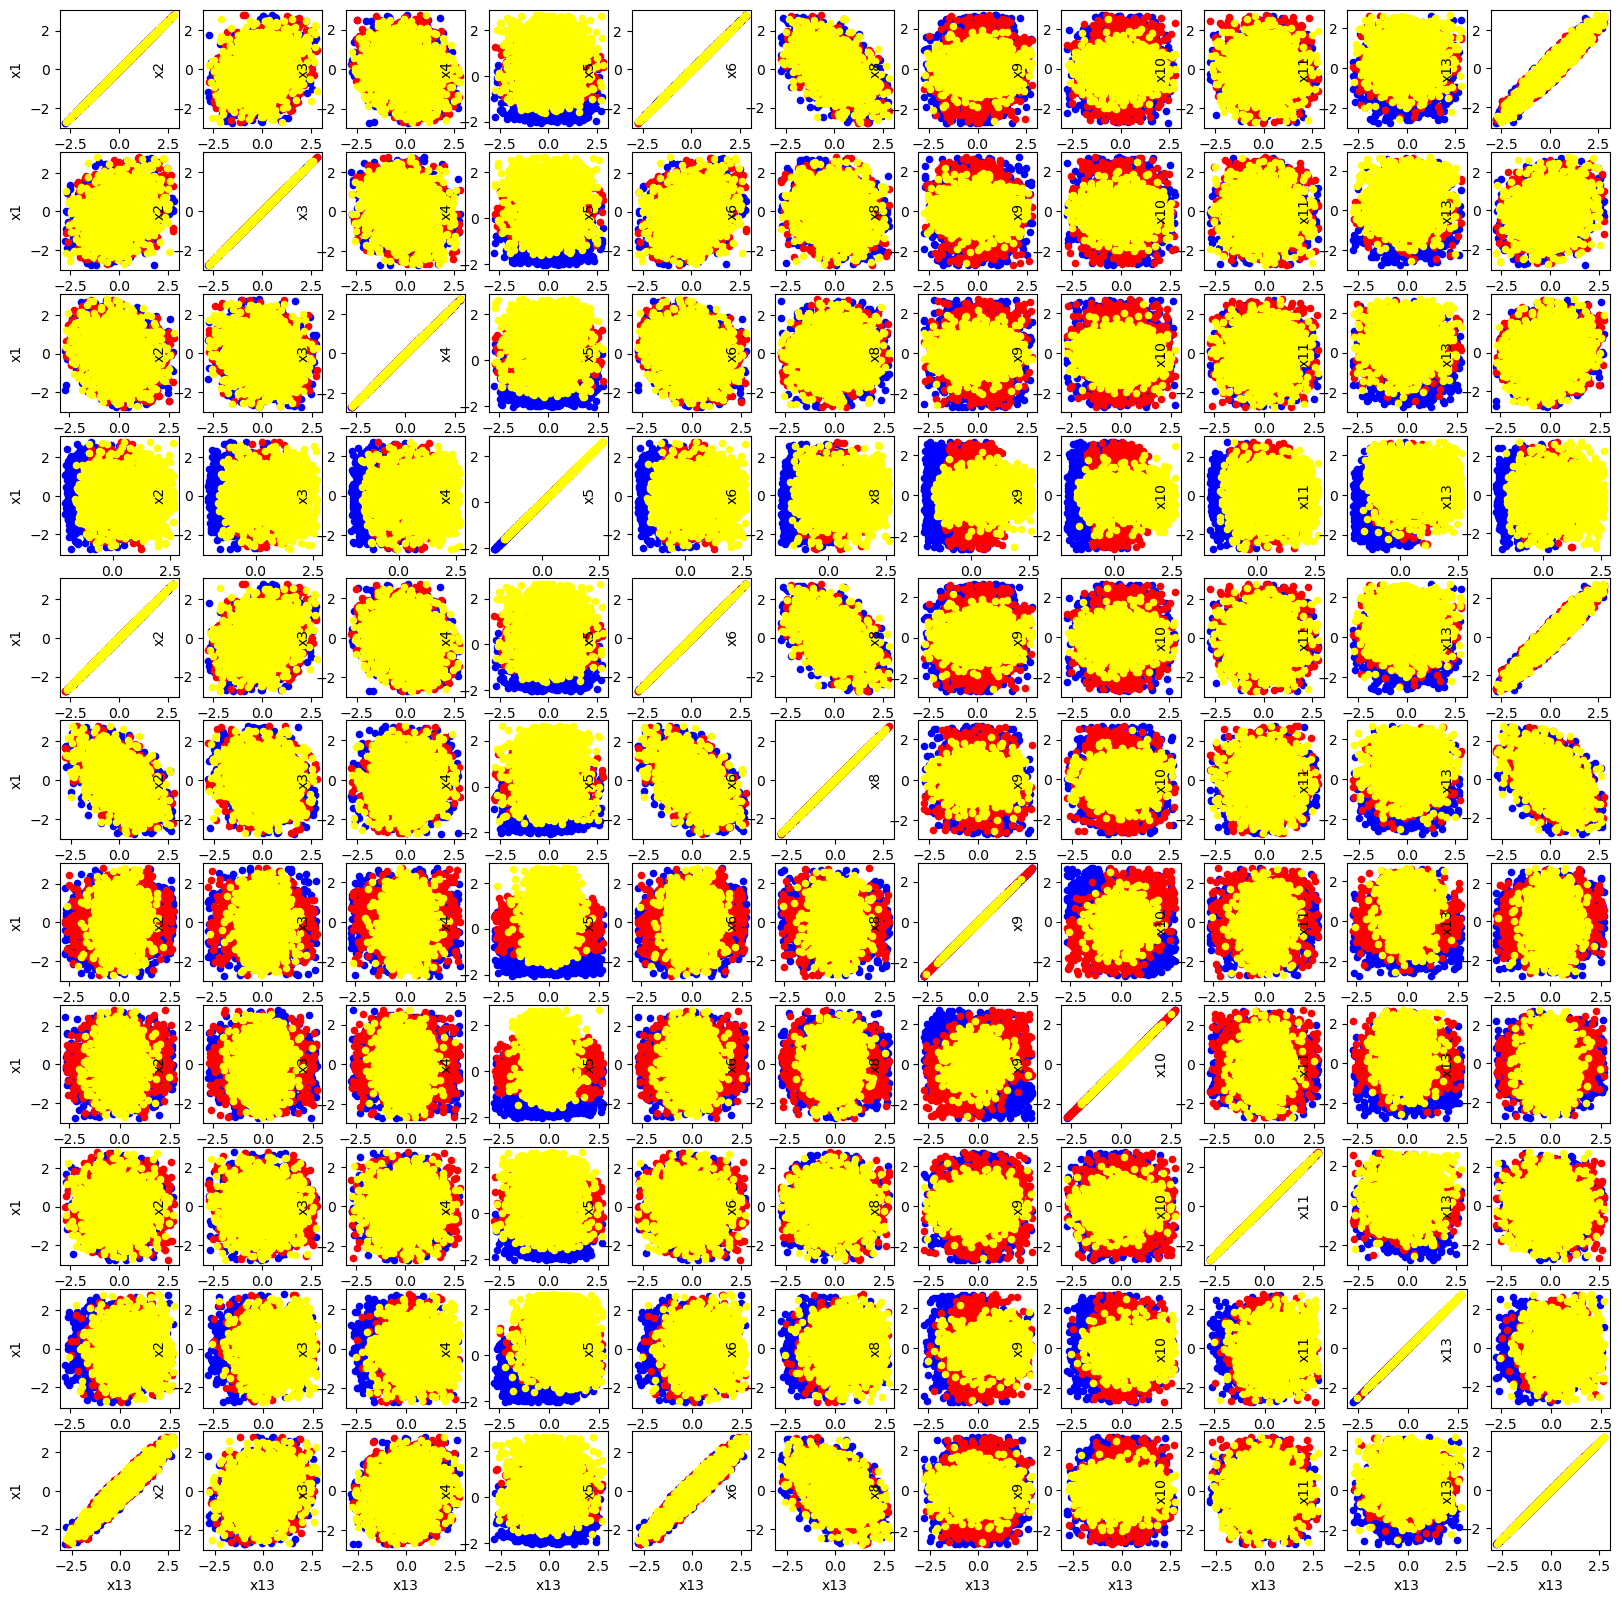

In [9]:
corrPlot(data, [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13])

x1, x13, x5 are highly correlating with each other. Lets drop x13.

In [10]:
data = data.drop(columns=["x13"])
print(data[['x1', 'x2', 'x3', 'x4', 'x5','x6', 'x7', 'x8', 'x9', 'x10', 'x11']].corr())

           x1        x2        x3        x4        x5        x6        x7  \
x1   1.000000  0.270245 -0.191748  0.003254  0.999725 -0.527602  0.184357   
x2   0.270245  1.000000 -0.177530 -0.007300  0.270207 -0.160608  0.051018   
x3  -0.191748 -0.177530  1.000000  0.016573 -0.192235  0.110048 -0.050454   
x4   0.003254 -0.007300  0.016573  1.000000 -0.016621  0.019806  0.006617   
x5   0.999725  0.270207 -0.192235 -0.016621  1.000000 -0.527903  0.184059   
x6  -0.527602 -0.160608  0.110048  0.019806 -0.527903  1.000000 -0.104351   
x7   0.184357  0.051018 -0.050454  0.006617  0.184059 -0.104351  1.000000   
x8   0.029055  0.010407 -0.025022 -0.012935  0.029458 -0.037399  0.005211   
x9   0.014639 -0.014277 -0.005649 -0.007338  0.014652 -0.023728  0.019183   
x10  0.016593  0.003238 -0.002985 -0.006595  0.016269 -0.016958 -0.002999   
x11  0.006163  0.003042 -0.009407  0.221025  0.004410  0.004250  0.003317   

           x8        x9       x10       x11  
x1   0.029055  0.014639  0.01

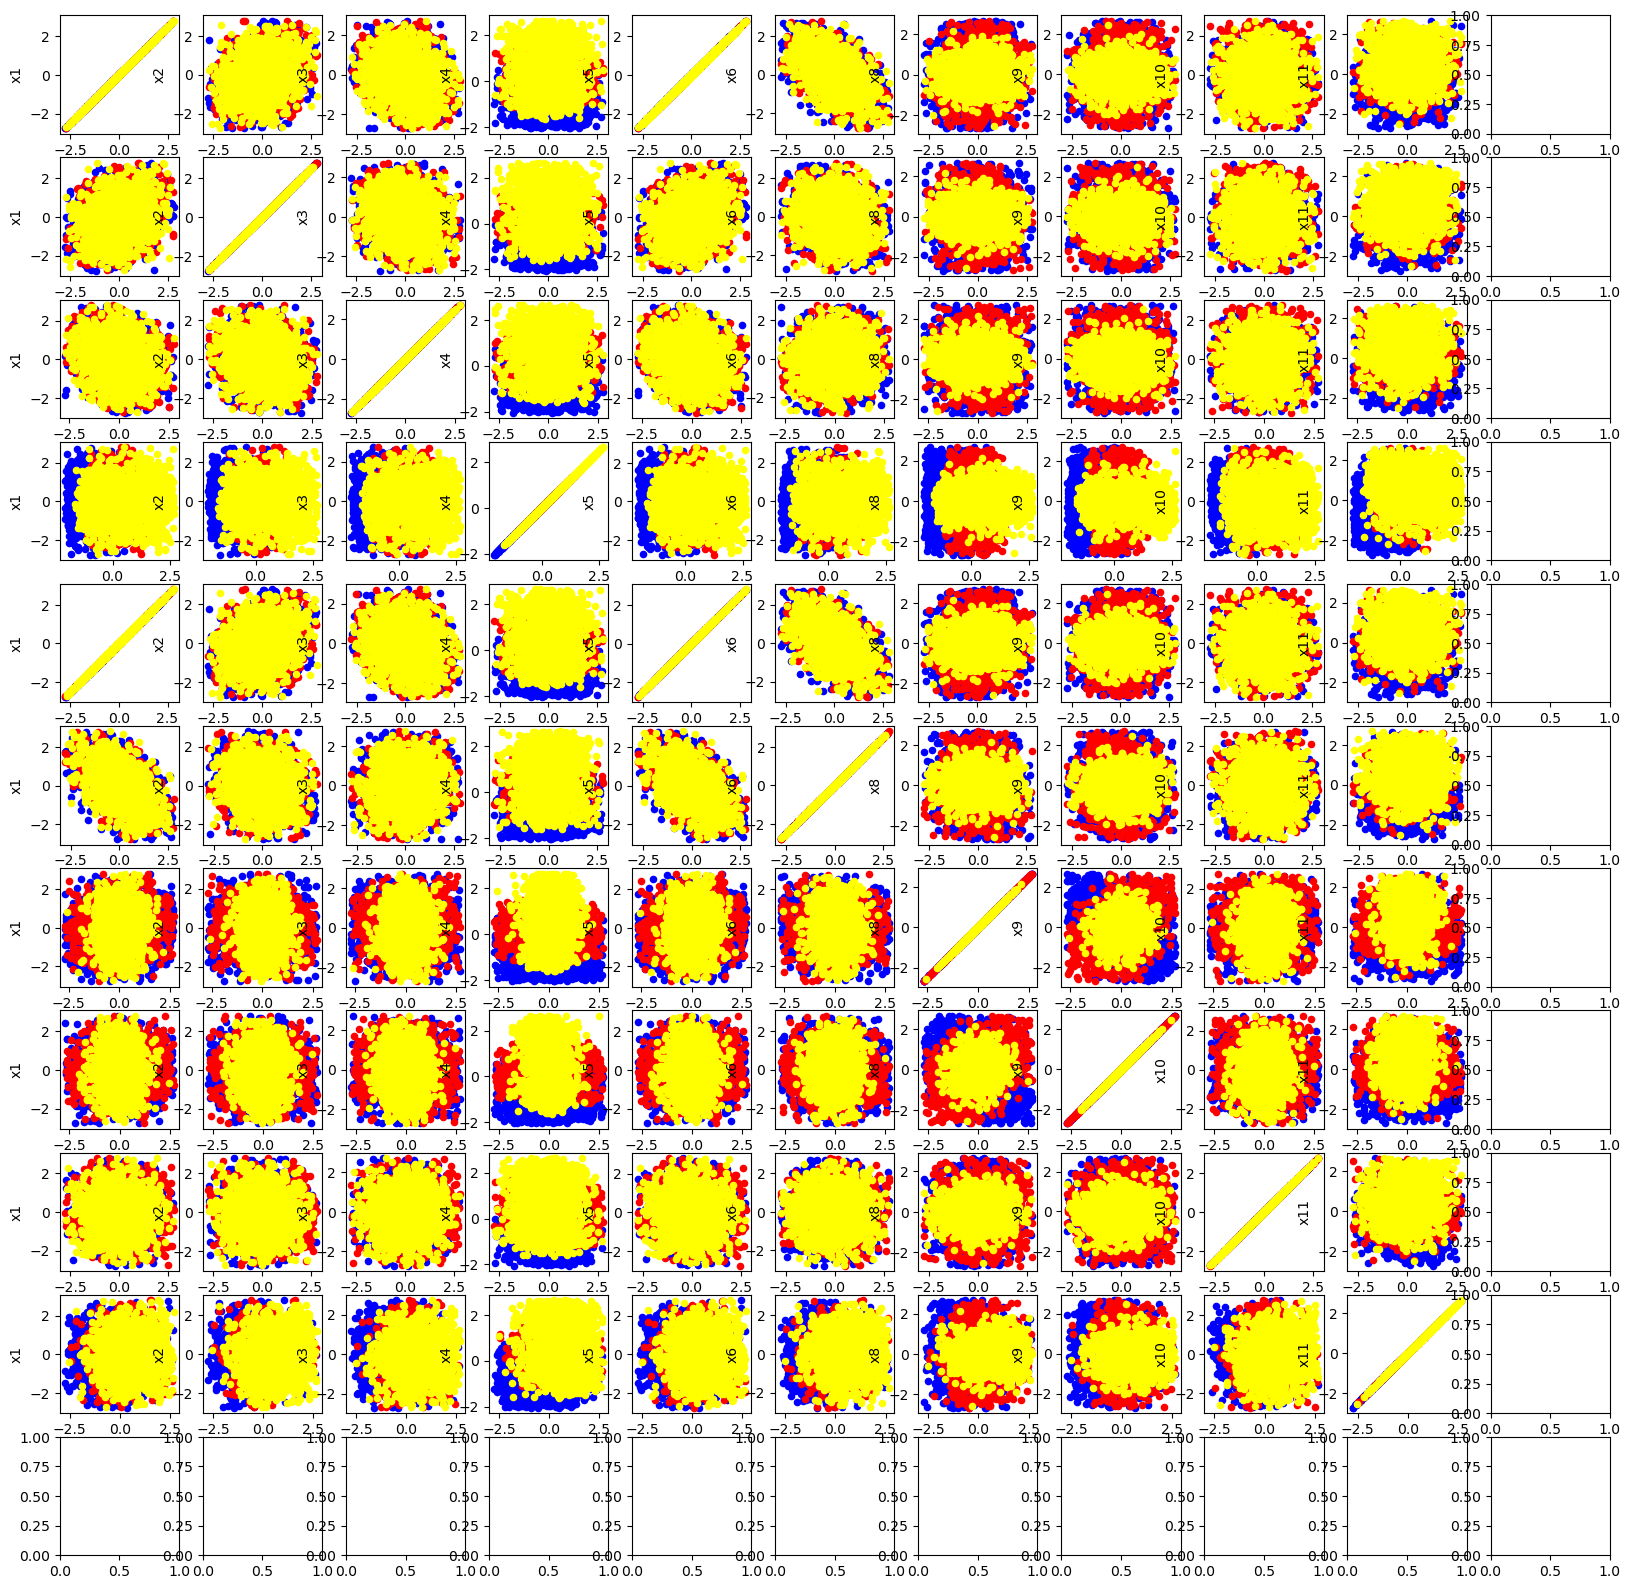

In [11]:
corrPlot(data, [1, 2, 3, 4, 5, 6, 8, 9, 10, 11])

Let's also drop x13 as the correlation still stands

In [ ]:
#data = data.drop(columns=["x13"])
#print(data[['x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']].corr())

In [ ]:
#corrPlot(data, [1, 2, 3, 4, 6, 8, 9, 10, 11])

In [12]:
pd.set_option('display.float_format', '{:.4f}'.format)
data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
count,4510.0000,4510.0000,4510.0000,4510.0000,4510.0000,4510.0000,4510.0000,4510.0000,4510.0000,4510.0000,4510.0000
mean,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,1.7461,0.0000,-0.0000,-0.0000,0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.1330,1.0001,1.0001,1.0001,1.0001
min,-2.7678,-2.7552,-2.7130,-2.0499,-2.7666,-2.7905,0.0000,-2.6704,-2.7134,-2.7578,-2.7319
25%,-0.6687,-0.6850,-0.6633,-0.7220,-0.6676,-0.6849,1.0000,-0.6331,-0.6674,-0.6923,-0.6975
50%,-0.0047,0.0037,-0.0040,-0.0590,-0.0063,-0.0038,2.0000,0.0004,-0.0038,-0.0146,-0.0460
75%,0.7084,0.6953,0.6762,0.6334,0.7108,0.6934,3.0000,0.6308,0.6502,0.6682,0.6425
max,2.8041,2.7790,2.7311,2.6471,2.8111,2.7992,4.0000,2.6744,2.6872,2.7703,2.6705


In [ ]:
y = data["y"]
X = data.drop(columns=["y"])

1        Apple
2         Meta
3         Meta
5       Google
6       Google
         ...  
4993      Meta
4994      Meta
4995     Apple
4996    Google
4998    Google
Name: y, Length: 4510, dtype: object


### PCA

In [14]:
pca = PCA(n_components=11, random_state=42)

X = pca.fit_transform(X)



# Lets try out different ML-models!

Catboost

In [15]:
cat = CatBoostClassifier(silent=True, random_state=42)

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=42)


cat.fit(Xtrain, ytrain)


yPredicted = cat.predict(Xtest) #testar!

#print accuracy
accuracy = accuracy_score(ytest, yPredicted)
print("Acc: ")
print(accuracy)
print("----------------------")
print(classification_report(ytest, yPredicted))

Acc: 
0.8493353028064993
----------------------
              precision    recall  f1-score   support

       Apple       0.87      0.92      0.90       279
      Google       0.89      0.89      0.89       217
        Meta       0.75      0.69      0.72       181

    accuracy                           0.85       677
   macro avg       0.84      0.83      0.84       677
weighted avg       0.85      0.85      0.85       677



Random Forest

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=42)
RForest = RandomForestClassifier(n_estimators=199, criterion='entropy',
                                    random_state=42)
RForest.fit(Xtrain, ytrain)
yPredicted = RForest.predict(Xtest)  # Predicting the Test set results

accuracy = accuracy_score(ytest, yPredicted)
print("Acc: ")
print(accuracy)
print("----------------------")
print(classification_report(ytest, yPredicted))

Acc: 
0.8212703101920237
----------------------
              precision    recall  f1-score   support

       Apple       0.84      0.93      0.88       279
      Google       0.85      0.88      0.87       217
        Meta       0.73      0.58      0.65       181

    accuracy                           0.82       677
   macro avg       0.81      0.80      0.80       677
weighted avg       0.81      0.82      0.81       677



XGBoost

In [18]:
conversionTo = {'Apple':0, 'Google':1, 'Meta':2}
conversionFrom = {0:'Apple',1:'Google',2:'Meta'}

#conversionTo = {'OpenAI':0, 'Antrophic':1, 'Mistral':2}
#conversionFrom = {0:'OpenAI',1:'Antrophic',2:'Mistral'}



Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=42)

ytrain_xb = ytrain.map(conversionTo)
ytest_xb = ytest.map(conversionTo)

xb=xgb.XGBClassifier(n_estimators=200,learning_rate=0.2,max_depth = 7,subsample=0.8,objective='multi:softmax', num_class=3,random_state=42)

xb.fit(Xtrain, ytrain_xb)
yPredicted = xb.predict(Xtest)  # Predicting the Test set results

accuracy = accuracy_score(ytest_xb, yPredicted)
print("Acc: ")
print(accuracy)
print("----------------------")
print(classification_report(ytest_xb, yPredicted))

Acc: 
0.8375184638109305
----------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       279
           1       0.89      0.88      0.88       217
           2       0.72      0.67      0.70       181

    accuracy                           0.84       677
   macro avg       0.83      0.82      0.82       677
weighted avg       0.84      0.84      0.84       677



# Let's Predict the Eval Set

Eval Compare:

In [ ]:
#eval_comp = list(pd.read_csv("./Classifier Testing/Evaluate Labeled.csv", names=["label"])["label"])

In [ ]:
eval = loadFromCSV("./Real Data/Evaluate.csv")
eval.dtypes

x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7      object
x8     float64
x9     float64
x10    float64
x11    float64
x12       bool
x13    float64
dtype: object

In [20]:
l0 = LabelEncoder()
eval["x7"] = lb.fit_transform(eval["x7"])
eval = eval.drop(columns=["x12"])


In [21]:
eval[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']] = StandardScaler().fit_transform(eval[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13']])
eval = eval.drop(columns=["x13"])

eval = pca.transform(eval)

### CatBoost

In [22]:
cat = CatBoostClassifier(silent=True, random_state=42)
cat.fit(X,y)
y_pred = cat.predict(eval)
print(y_pred)

[['Apple']
 ['Apple']
 ['Apple']
 ...
 ['Apple']
 ['Google']
 ['Apple']]


In [ ]:
counter = 0
for i in range(len(eval_comp)):
    if eval_comp[i].strip() == y_pred[i][0].strip():
        counter+=1

print("Accuracy: ", counter/len(eval_comp))

In [23]:
with open('catboost.txt', 'w', encoding='utf-8') as f:
    for label in y_pred:
        f.write(str(label[0]) + "\n")
f.close()

### Random Forest

In [24]:
RForest = RandomForestClassifier(n_estimators=199, criterion='log_loss',
                                    random_state=42)
RForest.fit(X, y)
y_pred = RForest.predict(eval)  # Predicting the Test set results
print(y_pred)

['Apple' 'Apple' 'Apple' ... 'Apple' 'Google' 'Apple']


In [ ]:
counter = 0
for i in range(len(eval_comp)):
    if eval_comp[i].strip() == y_pred[i].strip():
        counter+=1

print("Accuracy: ", counter/len(eval_comp))

In [25]:
with open('randf.txt', 'w', encoding='utf-8') as f:
    for label in y_pred:
        f.write(str(label) + "\n")
f.close()

### XGBoost

In [26]:
conversionTo = {'Apple':0, 'Google':1, 'Meta':2}
conversionFrom = {0:'Apple',1:'Google',2:'Meta'}

#conversionTo = {'OpenAI':0, 'Antrophic':1, 'Mistral':2}
#conversionFrom = {0:'OpenAI',1:'Antrophic',2:'Mistral'}

y_xb = y.map(conversionTo)


xb=xgb.XGBClassifier(n_estimators=200,learning_rate=0.2,max_depth = 7,subsample=0.8,objective='multi:softmax', num_class=3,random_state=42)

xb.fit(X, y_xb)
y_pred = xb.predict(eval)  # Predicting the Test set results



In [ ]:
counter = 0

for i in range(len(eval_comp)):

    if eval_comp[i].strip() == conversionFrom[y_pred[i]].strip():
        counter+=1

print("Accuracy: ", counter/len(eval_comp))

In [27]:
print(y_pred)
saveResultLabels(y_pred, "xgb.txt")

[0 0 0 ... 0 1 2]
